In [37]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import lazyqsar as lq
from rdkit.Chem import PandasTools


In [38]:
#Your dataset path
import os
filename = '/content/Final_processed.csv'
#current_directory = os.path.dirname(__file__)
#filename = os.path.join(current_directory, "..", "Data", "My_data", "Final_processed.csv")

In [39]:
import pandas as pd
df = pd.read_csv(filename)

In [40]:
#Visualizing our data
df

,SMILES,Active
0,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,1
1,C=CC1=C(C(=O)O)N2C(=O)[C@H]([C@H]2SC1)NC(=O)/C...,1
2,CC(=O)NC1=CC=C(C=C1)C2=CSC(=N2)C3=CN=CC=C3,0
3,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
4,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
...,...,...
260,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)C(=O)[C@H](C)...,1
261,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)N(C)C[C@H](C)...,0
262,C[C@@H]1CC(=O)[C@H](O)O[C@@H]([C@H]([C@@H]([C@...,0
263,C1CC1N2C=C(C(=O)C3=C2C=C(C(=C3)F)N4CCNCC4)C(=O)O,0


In [41]:
df.shape

(265, 2)

In [42]:
SMILES = "SMILES"
EXP = "Active"

In [43]:
import matplotlib.pyplot as plt
x = df[EXP]
print(x)

0      1
1      1
2      0
3      0
4      0
      ..
260    1
261    0
262    0
263    0
264    0
Name: Active, Length: 265, dtype: int64


(array([119.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 146.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

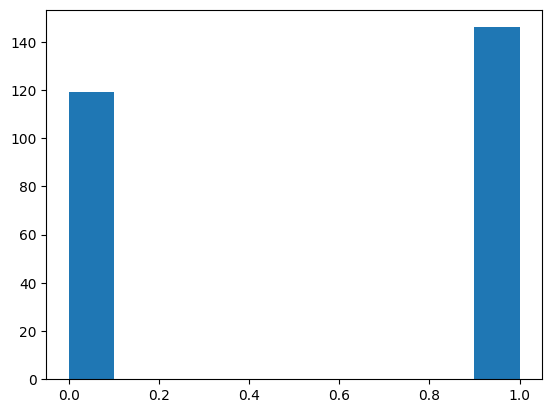

In [44]:
#Plotting to see the distribution of active and inactive we have in our dataset
plt.hist(x)

In [45]:
df

,SMILES,Active
0,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,1
1,C=CC1=C(C(=O)O)N2C(=O)[C@H]([C@H]2SC1)NC(=O)/C...,1
2,CC(=O)NC1=CC=C(C=C1)C2=CSC(=N2)C3=CN=CC=C3,0
3,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
4,CC(=O)NCC(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NC2(CCC...,0
...,...,...
260,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)C(=O)[C@H](C)...,1
261,CC[C@@H]1[C@](C)([C@@H]([C@@H](C)N(C)C[C@H](C)...,0
262,C[C@@H]1CC(=O)[C@H](O)O[C@@H]([C@H]([C@@H]([C@...,0
263,C1CC1N2C=C(C(=O)C3=C2C=C(C(=C3)F)N4CCNCC4)C(=O)O,0


In [46]:
print("Total molecules: ", len(df))
print("Active molecules: ", len(df[df[EXP]==1]))
print("Inactive molecules: ", len(df[df[EXP]==0]))
print("Frequency of Actives (%): ", len(df[df[EXP]==1])/len(df)*100)

Total molecules:  265
Active molecules:  146
Inactive molecules:  119
Frequency of Actives (%):  55.094339622641506


In [47]:
# Assuming SMILES and EXP are defined earlier in your code
SMILES = 'SMILES'
EXP = 'Active'

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df[SMILES], df[EXP], indices, test_size=size, stratify=df[EXP])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

In [48]:
train, test = random_split(df, 0.2)

In [49]:
smiles = train[SMILES]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

# Filter out None molecules
valid_mols = [mol for mol in mols if mol is not None]

# Specify the radius and number of bits for Morgan fingerprint
radius = 3
nBits = 2048

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in valid_mols]
morgan_fps_train = [np.array(list(fp.ToBitString())).astype(int) for fp in fps]




In [50]:
import lazyqsar as lq
import numpy as np
from sklearn.model_selection import KFold

# Filter out rows with None or invalid SMILES in the training set
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.MorganBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]
    print(y_hat)



Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-15 10:11:49] {2218} INFO - iteration 545, current learner xgboost
[flaml.automl.logger: 01-15 10:11:49] {2391} INFO -  at 310.9s,	estimator xgboost's best error=0.1608,	best estimator rf's best error=0.1600
[flaml.automl.logger: 01-15 10:11:49] {2218} INFO - iteration 546, current learner xgboost
[flaml.automl.logger: 01-15 10:11:49] {2391} INFO -  at 311.2s,	estimator xgboost's best error=0.1608,	best estimator rf's best error=0.1600
[flaml.automl.logger: 01-15 10:11:49] {2218} INFO - iteration 547, current learner rf
[flaml.automl.logger: 01-15 10:11:51] {2391} INFO -  at 312.6s,	estimator rf's best error=0.1600,	best estimator rf's best error=0.1600
[flaml.automl.logger: 01-15 10:11:51] {2218} INFO - iteration 548, current learner rf
[flaml.automl.logger: 01-15 10:11:52] {2391} INFO -  at 313.9s,	estimator rf's best error=0.1600,	best estimator rf's best error=0.1600
[flaml.automl.logger: 01-15 10:11:52] {22

### The ROC-AUC curve

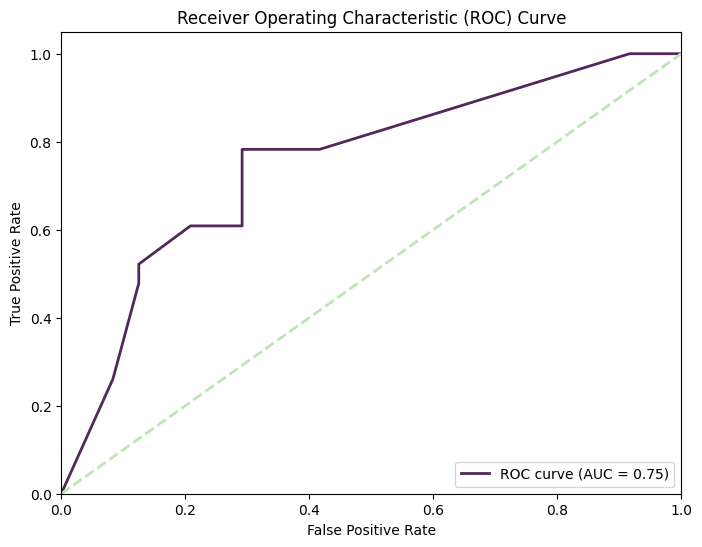

In [52]:
from sklearn.metrics import roc_curve, auc

# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[Text(0, 0.5, 'Inactive'), Text(0, 1.5, 'Active')]

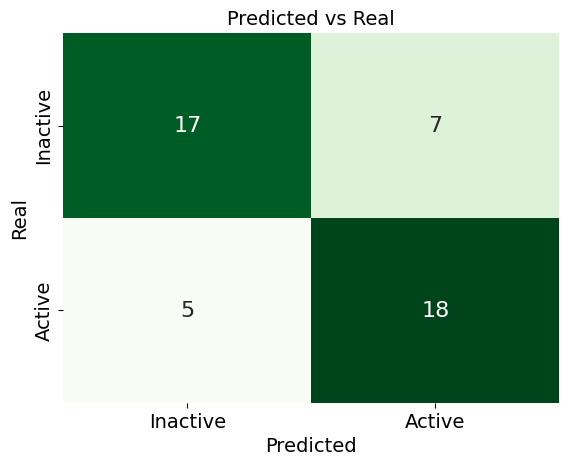

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

proba_cutoff = 0.5
y_hat_bin = [1 if x >= proba_cutoff else 0 for x in y_hat]


cf_matrix = confusion_matrix(y_test, y_hat_bin)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_hat_bin))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        24
           1       0.72      0.78      0.75        23

    accuracy                           0.74        47
   macro avg       0.75      0.75      0.74        47
weighted avg       0.75      0.74      0.74        47



In [56]:
model.save("model_morgan2.joblib")

In [66]:
import lazyqsar as lq
import numpy as np
from sklearn.model_selection import KFold

# Filter out rows with None or invalid SMILES in the training set
train = train.dropna(subset=[SMILES])
train = train[train[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

smiles_train = train[SMILES]
y_train = train[EXP]

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize and fit the model using cross-validation
for train_index, val_index in kf.split(smiles_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = smiles_train.iloc[train_index], smiles_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and fit the model
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train_fold, y_train_fold)

    # Filter out rows with None or invalid SMILES in the test set
    test = test.dropna(subset=[SMILES])
    test = test[test[SMILES].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Separate features (SMILES) for testing
    smiles_test = test[SMILES]

    # Predict probabilities using the trained model
    y_hat = model.predict_proba(smiles_test)

    y_hat = y_hat[:, 1]
    print(y_hat)



Streaming output truncated to the last 5000 lines.
[flaml.automl.logger: 01-15 11:14:20] {2218} INFO - iteration 651, current learner lgbm
[flaml.automl.logger: 01-15 11:14:21] {2391} INFO -  at 438.1s,	estimator lgbm's best error=0.1530,	best estimator lgbm's best error=0.1530
[flaml.automl.logger: 01-15 11:14:21] {2218} INFO - iteration 652, current learner lgbm
[flaml.automl.logger: 01-15 11:14:22] {2391} INFO -  at 438.8s,	estimator lgbm's best error=0.1530,	best estimator lgbm's best error=0.1530
[flaml.automl.logger: 01-15 11:14:22] {2218} INFO - iteration 653, current learner lgbm
[flaml.automl.logger: 01-15 11:14:22] {2391} INFO -  at 439.3s,	estimator lgbm's best error=0.1530,	best estimator lgbm's best error=0.1530
[flaml.automl.logger: 01-15 11:14:22] {2218} INFO - iteration 654, current learner lgbm
[flaml.automl.logger: 01-15 11:14:24] {2391} INFO -  at 441.0s,	estimator lgbm's best error=0.1530,	best estimator lgbm's best error=0.1530
[flaml.automl.logger: 01-15 11:14:24]

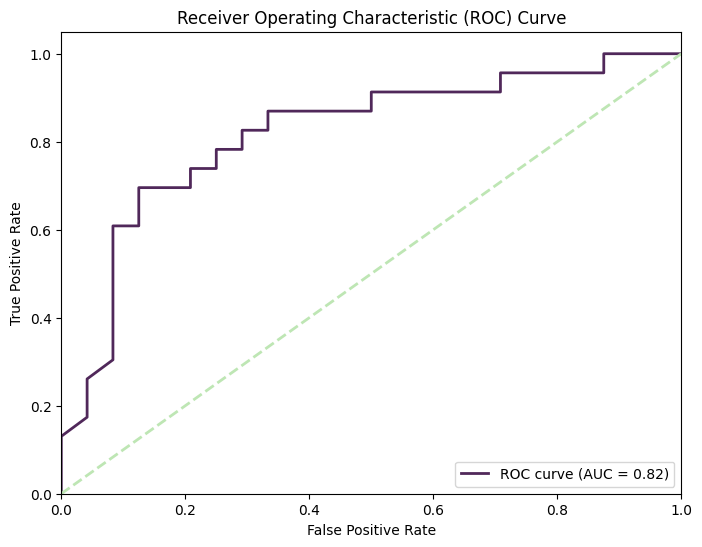

In [67]:
from sklearn.metrics import roc_curve, auc

# We need the real results, the activity of the test set
y_test = test[EXP]

# We use the sklearn package to calculate the roc_curve and plot it
fpr, tpr, _ = roc_curve(y_test, y_hat)
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#50285a', lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='#bee6b4', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[Text(0, 0.5, 'Inactive'), Text(0, 1.5, 'Active')]

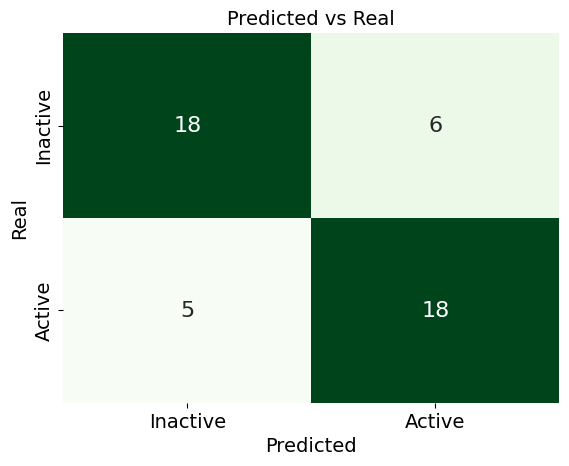

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

proba_cutoff = 0.5
y_hat_bin = [1 if x >= proba_cutoff else 0 for x in y_hat]


cf_matrix = confusion_matrix(y_test, y_hat_bin)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', cbar=False, annot_kws={"size": 16})
ax.set_title("Predicted vs Real", fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Inactive','Active'], fontsize=14)
ax.yaxis.set_ticklabels(['Inactive','Active'], fontsize=14)

In [70]:
model.save("model_eosce3.joblib")